In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
mnist = tf.keras.datasets.mnist
from sklearn.utils import shuffle

In [2]:
train = pd.read_csv("all/train.csv")
test = pd.read_csv("all/test.csv")

In [3]:
train = pd.DataFrame.as_matrix(train)

In [4]:
(_, _),(X_test, Y_test) = mnist.load_data()

In [5]:
X_test = X_test.astype("int64")
Y_test = Y_test.astype("int64")

In [6]:
np.random.shuffle(train)

In [7]:
X_original = train[:, 1:]
Y_original = train[:, 0]

In [8]:
X_original = X_original.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
X_original -= np.mean(X_original, axis=0).astype("int64")
X_original -= np.mean(X_original).astype("int64")

m = X_original.shape[0]

X_train = X_original[:int((4 / 5) * m), :, :]
Y_train = Y_original[:int((4 / 5) * m)]

X_dev = X_original[:3000, :]
Y_dev = Y_original[:3000]

X_val = X_original[int((4 / 5) * m):m, :, :]
Y_val = Y_original[int((4 / 5) * m):m]

print(X_val.shape, Y_val.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)

(8400, 28, 28) (8400,)
(3000, 28, 28) (3000,)
(10000, 28, 28) (10000,)


In [9]:
# Preprocessing: reshape the image data into rows
X_original = np.reshape(X_original, (X_original.shape[0], -1)).astype("float64")
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype("float64")
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype("float64")
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype("float64")
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1)).astype("float64")

# As a sanity check, print out the shapes of the data
print('Origninal training data shape: ', X_original.shape)
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Origninal training data shape:  (42000, 784)
Training data shape:  (33600, 784)
Validation data shape:  (8400, 784)
Test data shape:  (10000, 784)
dev data shape:  (3000, 784)


In [10]:
X_dev /= 255
X_train /= 255
X_val /= 255
X_original /= 255
X_test /= 255

In [11]:
def relu(x):
    return np.maximum(0, x)

In [12]:
def softmax(y):
    m = y.shape[0]
    n = y.shape[1]
    res = np.zeros((m, n))
    for i in range(m):
        res[i] = np.exp(y[i]) / np.sum(np.exp(y[i]))
        
    return res

result = softmax(np.random.random((100, 10)))

In [81]:
def param_init(n_in, n_hid, n_classes):

    W1 = np.random.randn(n_in, n_hid) / np.sqrt(n_in + n_hid)
    b1 = np.zeros((1, n_hid))
    W2 = np.random.randn(n_hid, n_classes) / np.sqrt(n_hid + n_classes)
    b2 = np.zeros((1, n_classes))
    
    return W1, b1, W2, b2

In [14]:
def forward_propagation(x, W1, b1, W2, b2, y):
    m = x.shape[0]
    z1 = np.dot(x, W1) + b1
    a1 = relu(z1) # shape is (m, 8)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2) # shape is (m ,10)
    
    return z1, a1, z2, a2

In [15]:
def compute_loss(a2, y, W1, W2, reg):
    m = y.shape[0]
    L = np.log(a2[range(m), y]) ### m=1 ?
    loss = -1 / m * np.sum(L) + 0.5 * reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
    
    return loss

In [16]:
def back_propagation(a2, y, W2, z1, a1, x):
    m = x.shape[0]
    dz2 = np.copy(a2)
    dz2[range(m), y] -= 1
    dW2 = (1 / m) * np.dot(a1.T, dz2)
    db2 = (1 / m) * np.sum(dz2, axis=0)
    d_relu = np.zeros((m, dW2.shape[0]))
    d_relu[z1 > 0] = 1
    dz1 = np.dot(dz2, W2.T) * d_relu
    dW1 = (1 / m) * np.dot(x.T, dz1)
    db1 = (1 / m) * np.sum(dz1, axis=0)
    
    return dW2, db2, dW1, db1

In [17]:
def param_update(W1, b1, W2, b2, learning_rate, reg):
    m = W1.shape[1]
    W1 -= learning_rate * (dW1 + (reg / m) * (W1))
    b1 -= learning_rate * db1
    W2 -= learning_rate * (dW2 + (reg / m) * (W2))
    b2 -= learning_rate * db2
    
    return W1, b1, W2, b2

In [18]:
def train(x, y, learning_rate, reg, epochs):
    m = x.shape[0]
    n_input = x.shape[1]
    L = np.array([])
    W1, b1, W2, b2 = param_init(n_input, n_hid=18, n_classes=10)

    for i in range(epochs):
        z1, a1, z2, a2 = forward_propagation(x, W1, b1, W2, b2, y)
        loss = compute_loss(a2, y, W1, W2, reg)
        L = np.append(L, loss)
        dW2, db2, dW1, db1 = back_propagation(a2, y, W2, z1, a1, x)
        W1, b1, W2, b2 = param_update(W1, b1, W2, b2, learning_rate, reg)
        print("epoch: ", i+1, ", loss is : ", loss, "da2[0] is ", a2[0])
    
    return a2, loss, L

In [83]:
epochs = 50
reg = 0.01
learning_rate = 0.5
learning_rate_decay = 0.95
n_input = X_train.shape[1]
L = np.array([])

train_acc = np.array([])
test_acc = np.array([])

train_loss = np.array([])
test_loss = np.array([])

W1, b1, W2, b2 = param_init(n_input, n_hid=20, n_classes=10)
for i in range(epochs):
    z1, a1, z2, a2 = forward_propagation(X_train, W1, b1, W2, b2, Y_train)
    train_loss = np.append(train_loss, compute_loss(a2, Y_train, W1, W2, reg))
    dW2, db2, dW1, db1 = back_propagation(a2, Y_train, W2, z1, a1, X_train)
    W1, b1, W2, b2 = param_update(W1, b1, W2, b2, learning_rate, reg)
#     print(np.mean(dW1) / W1)
    L = np.append(L, train_loss)
    learning_rate *= learning_rate_decay
    ### compute test loss ###
    _, _, _, a2_test = forward_propagation(X_test, W1, b1, W2, b2, Y_test)
    test_loss = np.append(test_loss, compute_loss(a2_test, Y_test, W1, W2, reg))
    
    train_acc = np.append(train_acc, accuracy(Y_train, a2))
    test_acc = np.append(test_acc, test_accuracy(W1, b1, W2, b2))
    ### early stopping
    if i>=1 and test_loss[i] < test_loss[i - 1]:
        break
    print("epoch ", i+1, "train loss is :", train_loss[i], " generalization loss is :", test_loss[i], "test accuracy is: ", test_acc[i])
print("Maximum test accuracy is :", np.max(test_acc), "% and it was achieved during", np.argmax(test_acc), "iteration")

epoch  1 train loss is : 2.432341997950336  generalization loss is : 2.3246416945660036 test accuracy is:  29.06
epoch  2 train loss is : 2.320399254264531  generalization loss is : 2.223961496582903 test accuracy is:  40.64
epoch  3 train loss is : 2.214282198051403  generalization loss is : 2.1254921897229586 test accuracy is:  45.34
epoch  4 train loss is : 2.1068924270344445  generalization loss is : 2.029585359330852 test accuracy is:  48.88
epoch  5 train loss is : 2.000122116643818  generalization loss is : 1.93757535518882 test accuracy is:  52.39
epoch  6 train loss is : 1.8962428810240037  generalization loss is : 1.8511587433786623 test accuracy is:  54.84
epoch  7 train loss is : 1.7979270215519625  generalization loss is : 1.7720177790279572 test accuracy is:  56.93
epoch  8 train loss is : 1.7077303236081567  generalization loss is : 1.7008605581554532 test accuracy is:  58.54
epoch  9 train loss is : 1.626642677431051  generalization loss is : 1.637529279347441 test accu

In [22]:
def accuracy(y, y_pred):
    count = 0
    m = y.shape[0]
    for i in range(m):
        count += (y[i] == np.argmax(y_pred[i]))
    acc = count * 100 / m
    
    return acc

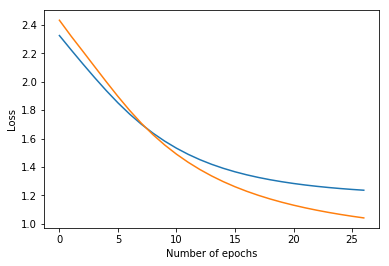

In [84]:
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(test_loss)
plt.plot(train_loss)

In [85]:
accuracy(Y_train, a2)

80.39880952380952

In [23]:
def test_accuracy(W1, b1, W2, b2):
    _, _, _, a2_test = forward_propagation(X_test, W1, b1, W2, b2, Y_test)
    loss_test = compute_loss(a2_test, Y_test, W1, W2, reg)
    test_acc = accuracy(Y_test, a2_test)
    return test_acc